### Verificación empírica de la complejidad algorítmica
Teoricamente llegamos a que el algoritmo tiene una complejidad de O(n).

A continuación se intentará verificar esto de manera empírica, generando un volumen de situaciones aleatorias con tamaño incremental, observando si el tiempo de resolución incrementa de forma lineal  

In [1]:
# Imports necesarios para el notebook
from random import seed

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp


In [2]:
# Funciones de utilidad
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 10

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = 96


def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

In [3]:
# Nuestra solucion al problema
def juego_monedas(monedas):
    turno = 0 # Los turnos pares son de Sophia, los impares de Mateo
    i = 0
    j = len(monedas) - 1

    acum_sophia = 0
    acum_mateo = 0
    while not (i > j):
        primera_moneda = monedas[i]
        ultima_moneda = monedas[j]
        if turno % 2 == 0:
            if primera_moneda > ultima_moneda:
                acum_sophia += primera_moneda
                i += 1
            else:
                acum_sophia += ultima_moneda
                j -= 1
        else:
            if primera_moneda < ultima_moneda:
                acum_mateo += primera_moneda
                i += 1
            else:
                acum_mateo += ultima_moneda
                j -= 1
        turno += 1

    return acum_sophia, acum_mateo

In [4]:
def get_random_array(size: int):
    return np.random.randint(0, 100.000, size)

# La variable x van a ser los valores del eje x de los gráficos en todo el notebook
# Tamaño mínimo=100, tamaño máximo=10kk, cantidad de puntos=20
x = np.linspace(100, 100_000_000, 20).astype(int)

results = time_algorithm(juego_monedas, x, lambda s: [get_random_array(s)])

### Ejecutamos el algoritmo para casos aleatorios de hasta 10 millones de elementos, se observa el siguiente crecimiento:

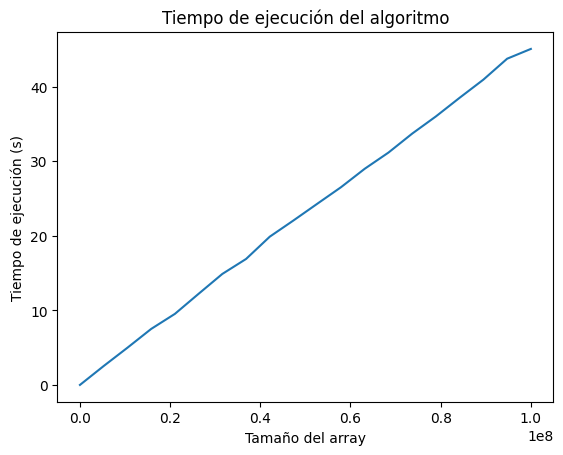

In [5]:
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución del algoritmo')
ax.set_xlabel('Tamaño del array')
ax.set_ylabel('Tiempo de ejecución (s)')
None

In [6]:
### Luego calculamos el error cuadratico :

In [11]:
f = lambda x, c1, c2: c1 * x + c2

c, pcov = sp.optimize.curve_fit(f, x, [results[n] for n in x])

print(f"c_1 = {c[0]}, c_2 = {c[1]}")
r = np.sum((c[0] * x + c[1] - [results[n] for n in x])**2)
print(f"Error cuadrático medio: {r/len(results)}")

c_1 = 4.5442813336079017e-07, c_2 = 0.25490779887957365
Error cuadrático medio: 0.06292763884521292


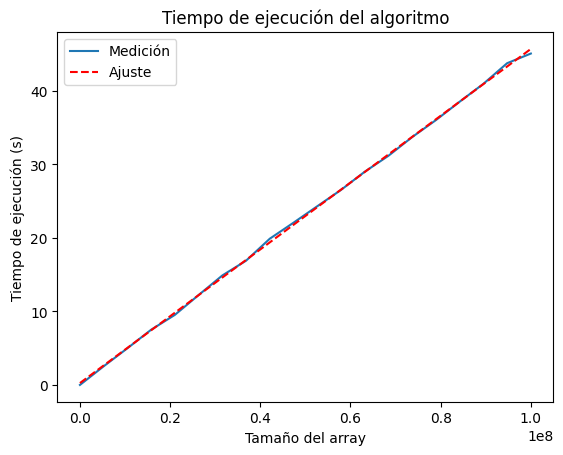

In [8]:
ax.plot(x, [c[0] * n + c[1] for n in x], 'r--', label="Ajuste")
ax.legend()
fig